<a href="https://colab.research.google.com/github/Kraken2003/Lofi-Gen/blob/main/LofiGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pickle
import os
from music21 import converter, instrument, note, chord
from music21 import stream
import numpy as np
import keras
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Flatten
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
import pandas as pd
import glob

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
with open('/content/drive/MyDrive/lofimidi/big_notes', 'rb') as filepath:
  notes = pickle.load(filepath)

In [4]:
len(notes)

510190

In [5]:
notes[0:10]

['F#5', 'E5', 'D5', 'E5', 'F#5', 'E5', 'F#5', 'G5', 'F#5', 'E5']

In [6]:
len(set(notes[0:10]))

4

In [4]:
def process_notes(notes):

    seqLength = 50
    print('Using sequence length of {}'.format(seqLength))

    pitchSet = sorted(set(notes))
    numPitches = len(pitchSet)
    print('Identified {} pitches'.format(numPitches))

    # Map each note/chord to a number normalized to (0,1)
    pitchMapping = dict((note, number) for (number, note) in enumerate(pitchSet))

    networkInput = []
    networkOutput = []

    print('Starting sequencing of {} notes'.format(len(notes)))
    for i in range(0, len(notes)- seqLength):
        sequenceIn = notes[i:i+seqLength]
        predictionOut = notes[i+seqLength]

        networkInput.append([pitchMapping[note] for note in sequenceIn])
        networkOutput.append(pitchMapping[predictionOut])

        if (i+1) % 50000 == 0:
            print('Finished making {} sequences'.format(i+1))

    networkInput = np.array(networkInput)
    networkOutput = np.array(networkOutput)
    numSeqs = len(networkInput)

    # reshape input to match the LSTM layer format
    networkInput = np.reshape(networkInput, (numSeqs, seqLength, 1))
    networkInput = networkInput / float(numPitches)
    #print("The input shape for network is: ", networkInput)

    networkOutput = to_categorical(networkOutput)
    #print("The output shape for network is: ", networkOutput)


    return networkInput, networkOutput, numPitches

In [8]:
notes1 = notes[0:100000]
networkInput, networkOutput, numPitches = process_notes(notes1)

Using sequence length of 100
Identified 492 pitches
Starting sequencing of 100000 notes
Finished making 50000 sequences


In [9]:
def create_model(ninput, numPitches):
  model = Sequential()

  model.add(LSTM(
        512,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=True
    ))
  model.add(BatchNorm())
  model.add(Dropout(0.3))

  model.add(LSTM(512, return_sequences=True))
  model.add(BatchNorm())
  model.add(Dropout(0.3))

  model.add(LSTM(
        512,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=False
    ))
  model.add(BatchNorm())
  model.add(Dropout(0.3))

  model.add(Dense(256))
  model.add(Activation('relu'))

  model.add(Dense(numPitches))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

In [10]:
model = create_model(networkInput, numPitches)

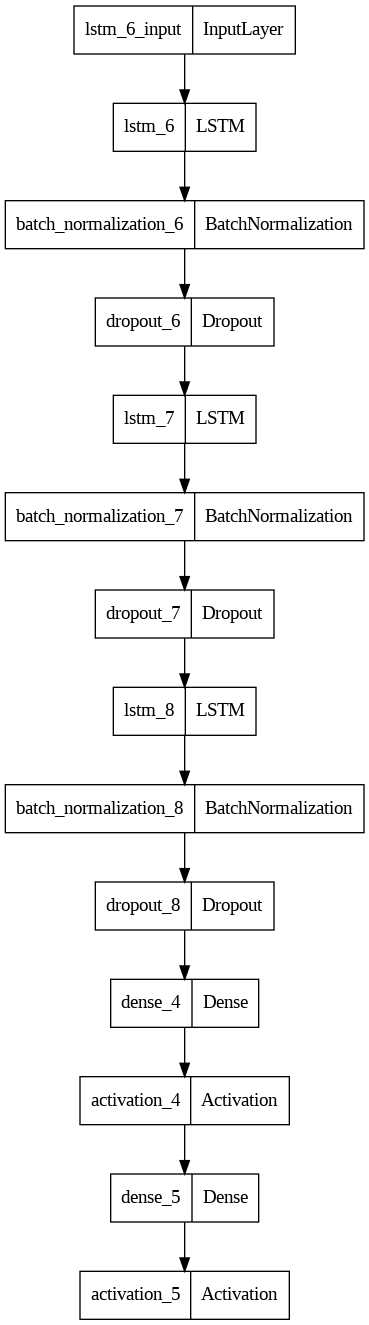

In [25]:
from keras.utils import plot_model
plot_model(model)

In [5]:
def model_train(model, network_input, network_output, num_epochs, batchs):

    filepath = r'/content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger_1.hdf5'

    checkpoint = ModelCheckpoint(
        filepath, monitor='loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    history = model.fit(network_input, network_output, epochs=num_epochs, batch_size=batchs, callbacks=callbacks_list)

    return history

In [28]:
model_train(model,networkInput,networkOutput,num_epochs = 10, batchs = 128)

Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 4.5690 - accuracy: 0.0592
Epoch 1: loss improved from inf to 4.56896, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-01-4.5690-bigger_1.hdf5
781/781 [==============================] - 120s 154ms/step - loss: 4.5690 - accuracy: 0.0592
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


781/781 [==============================] - ETA: 0s - loss: 4.1780 - accuracy: 0.1104
Epoch 2: loss improved from 4.56896 to 4.17799, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-02-4.1780-bigger_1.hdf5
781/781 [==============================] - 122s 156ms/step - loss: 4.1780 - accuracy: 0.1104
Epoch 3/10
781/781 [==============================] - ETA: 0s - loss: 3.8097 - accuracy: 0.1660
Epoch 3: loss improved from 4.17799 to 3.80975, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-03-3.8097-bigger_1.hdf5
781/781 [==============================] - 122s 156ms/step - loss: 3.8097 - accuracy: 0.1660
Epoch 4/10
781/781 [==============================] - ETA: 0s - loss: 3.5280 - accuracy: 0.2039
Epoch 4: loss improved from 3.80975 to 3.52796, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-04-3.5280-bigger_1.hdf5
781/781 [======

# **GENERATING MIDI FILES**

In [11]:
model.load_weights(r'/content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-10-2.9407-bigger_1.hdf5')

In [15]:
def generate_notes(model, network_input, pitchnames, n_vocab):

    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []


    for note_index in range(200):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        #pattern.append(index)
        #np.append(pattern,index)
        #pattern = pattern[1:len(pattern)]

        pattern.ravel()
        patternbeta =  pattern + index
        patternbeta = patternbeta[1:len(patternbeta)]

    return prediction_output

In [30]:
def generate_notes(model, network_input, pitchnames, n_vocab, temperature=1.5):
    """ Generate notes from the neural network based on a sequence of notes """
    start = np.random.randint(0, len(network_input) - 1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    for note_index in range(100):
        #print(note_index)
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        # Adjust temperature
        prediction = model.predict(prediction_input, verbose=0).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # Sample from the adjusted distribution
        index = np.random.choice(len(prediction[0]), p=prediction[0])

        result = int_to_note[index]
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [13]:
# Get all pitch names
pitchnames = sorted(set(item for item in notes1))
# Get all pitch names
n_vocab = len(set(notes1))

In [32]:
prediction_output = generate_notes(model,networkInput,pitchnames,n_vocab)

<ipython-input-31-1d8749f6f8d0>:17: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


In [31]:
def create_midi(prediction_output):

    offset = 0
    output_notes = []

    for pattern in prediction_output:

        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)


        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='lofi_output14.mid')

In [34]:
create_midi(prediction_output)

# DIFFERENT MODEL PARAM

In [6]:
with open('/content/drive/MyDrive/lofimidi/othernotes', 'rb') as filepath:
  notes = pickle.load(filepath)

In [7]:
len(notes)

3130

In [8]:
networkInput, networkOutput, numPitches = process_notes(notes)

Using sequence length of 50
Identified 285 pitches
Starting sequencing of 3130 notes


In [9]:
def create_network(ninput, numPitches):

    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))

    model.add(LSTM(512,
                   return_sequences=True,
                   recurrent_dropout=0.3))

    model.add(LSTM(512))

    model.add(Flatten())
    model.add(BatchNorm())
    model.add(Dropout(0.3))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNorm())

    model.add(Dropout(0.3))
    model.add(Dense(numPitches))

    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [10]:
model = create_network(networkInput, numPitches)

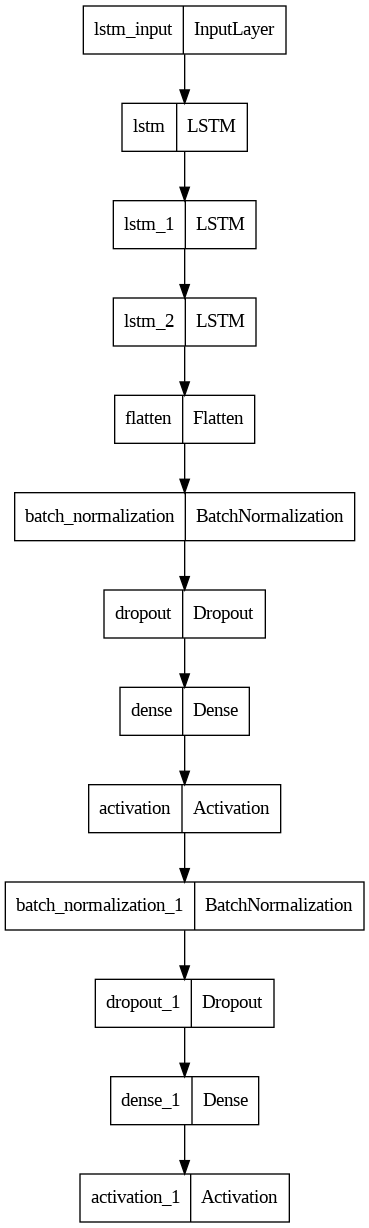

In [11]:
from keras.utils import plot_model
plot_model(model)

In [13]:
model_train(model, networkInput, networkOutput, num_epochs = 100, batchs = 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 5.7498 - accuracy: 0.0182
Epoch 1: loss improved from inf to 5.74977, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-01-5.7498-bigger_1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 15s 316ms/step - loss: 5.7498 - accuracy: 0.0182
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 5.5955 - accuracy: 0.0218
Epoch 2: loss improved from 5.74977 to 5.59554, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-02-5.5955-bigger_1.hdf5
49/49 [==============================] - 15s 303ms/step - loss: 5.5955 - accuracy: 0.0218
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 5.5879 - accuracy: 0.0195
Epoch 3: loss improved from 5.59554 to 5.58795, saving model to /content/drive/MyDrive/lofimidi/midi_dataset/lofi-samples/weights/weights-improvement-03-5.5879-bigger_1.hdf5
49/49 [==============================] - 15s 311ms/step - loss: 5.5879 - accuracy: 0.0195
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 5.5037 - accuracy: 0.0166
Epoch 4: loss improved from 5.58795 to 5.50366, saving model to /content/drive/MyDrive/lofimidi/m

In [17]:
# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

In [32]:
prediction_output = generate_notes(model,networkInput,pitchnames,n_vocab)

In [33]:
create_midi(prediction_output)